# **Multiple Linear Regression**

## 3. Ajuste um Modelo de Regressão Linear Múltipla
### Ajuste um modelo de regressão linear múltipla considerando todas as variáveis do seu conjunto de dados. Apresente os valores numéricos de da matriz $X^TX$ e sua inversa. Assim como da matriz $X^TY$ e estimativas do vetor $\beta's$ dos e intérprete. Explique se existe diferença entre o EMV e o estimador de mínimos quadrados de $\beta$? justifique

### Como o estimador mínimos quadrados de $\beta$ é $\hat \beta  = (X^TX)^{-1}X^TY$, segue que $\hat Y = X \hat \beta = X(X^TX)^{-1}X^TY$

In [1946]:
class Multiple_Linear_Regression:
    
    def __init__(self, description = False):
        
        self._description = description
        self._fit = False 
    
    def fit(self, X, Y, n = None):
        
        self._X_init = X
        self._Y = Y
        
        if n != None and type(n) == int:
            self._X_init.iloc[:, :n]
        
        return self._mlr()
    
    def _mlr(self):
        
        self._X = np.append(np.ones((self._X_init.shape[0], 1)), self._X_init, axis = 1)

        self._column_XX = self._X.T @ self._X
        self._inv_column_XX = linalg.inv(self._column_XX)

        self._column_XY = self._X.T @ self._Y

        self._beta_hat = self._inv_column_XX @ self._column_XY
        
        self._Y_hat = self._X @ self._beta_hat
        
        self._res = self._Y - self._Y_hat
        
        self._fit = True
        
        return self._beta_hat
    
    def predict(self, X_init):
        
        try:
            
            X = np.append(np.ones((X_init.shape[0], 1)), X_init, axis = 1)
            
            return X @ self._beta_hat
            
        except:
            
            print('A matriz de valores é imcompatível.')
            
        return None
    
    def estimations(self):
        
        if self._fit:
        
            n, p = self._X.shape
        
            self._SQtotal = self._Y.T @ self._Y - n*self._Y.mean()**2
            self._SQreg = self._beta_hat @ self._column_XY - n*self._Y.mean()**2
            self._SQres = self._SQtotal - self._SQreg
            
            self._QMres = self._SQres/(n - p)
            self._QNres = self._SQres/n
            
            self._QMreg = self._SQreg/(p - 1)
            
            self._F0 = self._QMreg/self._QMres
            
            self._R2 = self._SQreg/self._SQtotal
            self._R2_aj = 1 - self._QMres/(self._SQtotal/(n - 1))
            
            return {'SQtotal': self._SQtotal, 'SQres': self._SQres, 'SQreg': self._SQreg ,'QMres': self._QMres, 'QNres': self._QNres, 'QMreg': self._QMreg, 'R2': self._R2,'R2_aj': self._R2_aj}
        
        else:
            
            print('O modele ainda não foi treinado.')
        
        return None
    
    def ANOVA(self, alpha = 0.05):
        
        n, p = self._X.shape
        
        est = self.estimations()
        
        self._F = stats.f.ppf(1 - alpha, p - 1, n - p)
        
        s = f"Fonte de Variação(FV) \t g.l              \t SQ              \t QM              \t F \n\n"
        
        
        s += f"Regressão           \t {p-1}                \t {est['SQreg']:.2f}          \t {est['QMreg']:.2f}          \t {est['QMreg']/est['QMres']:.2f}\n"
        s += f"Resíduo             \t {n - p}              \t {est['SQres']:.2f}              \t {est['QMres']:.2f} \n\n"
        
        s += f"Total               \t {n - 1}              \t {est['SQtotal']:.2f}\n\n"
        
        print(s)
        
        
        print(self._F0, self._F)
        
        if self._F0 > self._F:
            
            print(f"Como F0 = {self._F0:.2f} > F = {self._F:.2f}, rejeitamos H0: Pelo menos uma das covariáveis é significativa.")
        
        else:
            
            print(f"Como F = {self._F:.2f} > F0 = {self._F0:.2f}, aceitamos H0: Nenhuma das covariáveis é significativa.")
    
    def coeficient_test(self, alpha = 0.05):
        
        n, p = self._X.shape
        
        ta = stats.t.ppf(alpha/2, n - p)
        tb = stats.t.ppf(1 - alpha/2, n - p)
        
        for i, beta_i in enumerate(self._beta_hat):
            
            t = beta_i/(np.sqrt(self._QMres*self._inv_column_XX[i,i]))
            
            if t < ta or t > tb:
                
                print(f"Como t = {t:.2f} não pertence ao intervalo [{ta:.2f},{tb:.2f}], rejeitamos H0: A covariável X_{i} é significativa, dadas as demais no modelo.")
            
            else:
                
                print(f"Como t = {t:.2f} pertence ao intervalo [{ta:.2f},{tb:.2f}], não rejeitamos H0: A covariável X_{i} não é significativa, dadas as demais no modelo.")
    
    def ICs(self, alpha = 0.05):
        
        n, p = self._X.shape
        
        ta = stats.t.ppf(1 - alpha/2, n - p)
        tb = stats.t.ppf(alpha/2, n - p)
        
        ICs = {}
        
        for i, beta_i in enumerate(self._beta_hat):
            
            dp_b1 = np.sqrt(self._QMres*self._inv_column_XX[i,i])
            
            ICs[f'Beta {i}'] = [beta_i - ta*dp_b1, beta_i - tb*dp_b1]
    
        return ICs
    
    def IC_mean(self, X, alpha = 0.05):
        
        X0 = np.append(np.array([1]), X)
        Y0 = X0 @ self._beta_hat
        
        n, p = self._X.shape
        
        ta = stats.t.ppf(1 - alpha/2, n - p)
        tb = stats.t.ppf(alpha/2, n - p)
        
        dp_b = np.sqrt(self._QMres* (X0 @ self._inv_column_XX @ X0.T))
        
        IC = [Y0 - ta*dp_b, Y0 - tb*dp_b]
        
        return IC
    
    @staticmethod
    def sub_set_test(X, Y, sub, alpha = 0.05):
        
        r = len(sub)
        
        n, k = X.shape
        p = k + 1
        
        F = stats.f.ppf(1 - alpha, r, n - p)
        
        mlr1 = Multiple_Linear_Regression()
        mlr = Multiple_Linear_Regression()
        
        X_1 = X[sub]
        
        beta_1 = mlr1.fit(X_1, Y)
        est_1 = mlr1.estimations()
        
        beta = mlr.fit(X, Y)
        est = mlr.estimations()
        
        SQreg = est['SQreg'] - est_1['SQreg'] 
        
        F0 = SQreg/r/(est['SQres']/(n - p))
        
        if F0 > F:
            
            print(f"Como F0 = {F0:.2f} > F = {F:.2f}, rejeitamos H0: Ao menos uma das covariáveis no sub conjunto é significativa.")
        
        else:
            
            print(f"Como F = {F:.2f} > F0 = {F0:.2f}, aceitamos H0: Nenhuma das covariáveis no sub conjunto é significativa.")

## **Dados do Trabalho**

In [1947]:
df = pd.read_csv('B13.csv')

In [1948]:
df.head(5)

,y,x1,x2,x3,x4,x5,x6
0,4540,2140,20640,30250,205,1732,99
1,4315,2016,20280,30010,195,1697,100
2,4095,1905,19860,29780,184,1662,97
3,3650,1675,18980,29330,164,1598,97
4,3200,1474,18100,28960,144,1541,97


In [1949]:
Y = df['y']
X = df.iloc[:, 1:]

## **Questão - 3** Aula 11

In [1950]:
mlr = Multiple_Linear_Regression()

In [1951]:
mlr.fit(X, Y)

array([-4.73801490e+03,  1.11850844e+00, -3.01839562e-02,  2.30618802e-01,
        3.84954863e+00,  8.21863660e-01, -1.69464566e+01])

## **Questão - 4** ($\hat \sigma = QMres$) Aula 12

In [1952]:
mlr.estimations()

{'SQtotal': 9932036.0,
 'SQres': 23189.608456730843,
 'SQreg': 9908846.39154327,
 'QMres': 702.7154077797225,
 'QNres': 579.7402114182711,
 'QMreg': 1651474.398590545,
 'R2': 0.9976651707206124,
 'R2_aj': 0.9972406563061784}

(array([1., 3., 5., 5., 8., 6., 3., 4., 2., 3.]),
 array([-49.94850163, -39.99305931, -30.037617  , -20.08217468,
        -10.12673236,  -0.17129005,   9.78415227,  19.73959459,
         29.6950369 ,  39.65047922,  49.60592154]),
 <BarContainer object of 10 artists>)

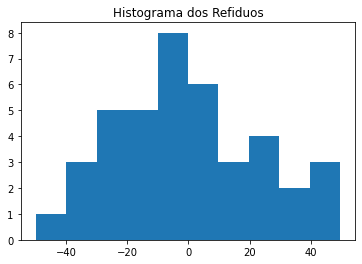

In [1953]:
plt.title('Histograma dos Refiduos')

plt.hist(mlr._res)

## **Questão - 5** Aula 13

In [1954]:
mlr.ANOVA()

Fonte de Variação(FV) 	 g.l              	 SQ              	 QM              	 F 

Regressão           	 6                	 9908846.39          	 1651474.40          	 2350.13
Resíduo             	 33              	 23189.61              	 702.72 

Total               	 39              	 9932036.00


2350.132614579338 2.389393897988133
Como F0 = 2350.13 > F = 2.39, rejeitamos H0: Pelo menos uma das covariáveis é significativa.


## **Questão - 6** Aula 13

In [1955]:
mlr.estimations()

{'SQtotal': 9932036.0,
 'SQres': 23189.608456730843,
 'SQreg': 9908846.39154327,
 'QMres': 702.7154077797225,
 'QNres': 579.7402114182711,
 'QMreg': 1651474.398590545,
 'R2': 0.9976651707206124,
 'R2_aj': 0.9972406563061784}

## **Questão - 7** Aula 13

In [1956]:
mlr.coeficient_test()

Como t = -1.94 pertence ao intervalo [-2.03,2.03], não rejeitamos H0: A covariável X_0 não é significativa, dadas as demais no modelo.
Como t = 3.90 não pertence ao intervalo [-2.03,2.03], rejeitamos H0: A covariável X_1 é significativa, dadas as demais no modelo.
Como t = -0.79 pertence ao intervalo [-2.03,2.03], não rejeitamos H0: A covariável X_2 não é significativa, dadas as demais no modelo.
Como t = 1.95 pertence ao intervalo [-2.03,2.03], não rejeitamos H0: A covariável X_3 não é significativa, dadas as demais no modelo.
Como t = 1.43 pertence ao intervalo [-2.03,2.03], não rejeitamos H0: A covariável X_4 não é significativa, dadas as demais no modelo.
Como t = 2.34 não pertence ao intervalo [-2.03,2.03], rejeitamos H0: A covariável X_5 é significativa, dadas as demais no modelo.
Como t = -6.47 não pertence ao intervalo [-2.03,2.03], rejeitamos H0: A covariável X_6 é significativa, dadas as demais no modelo.


## **Questão - 8** Aula 14

In [1957]:
mlr.sub_set_test(X, Y, ['x2', 'x3', 'x4'])

Como F0 = 28.14 > F = 2.89, rejeitamos H0: Ao menos uma das covariáveis no sub conjunto é significativa.


## **Questão - 9** Aula 15

In [1958]:
mlr.ICs()

{'Beta 0': [-9711.87348291813, 235.84368178783552],
 'Beta 1': [0.5356848490111925, 1.7013320392877749],
 'Beta 2': [-0.10797076009462894, 0.04760284774088855],
 'Beta 3': [-0.009513280193777368, 0.4707508850618518],
 'Beta 4': [-1.615633577038576, 9.31473084217873],
 'Beta 5': [0.10825876843932392, 1.5354685525201184],
 'Beta 6': [-22.277061397199333, -11.615851832564175]}

## **Questão - 10** Aula 15

In [1963]:
mlr.IC_mean(np.array([2140, 20640, 30250, 205, 1732, 99]))

[4524.299819265233, 4563.18260635121]

## **Dados Da Aula**

In [1964]:
df_aula = pd.read_csv('dadosexemplotempodeentrega.csv', ';')

In [1965]:
df_aula['tempodeentrega'] = df_aula['tempodeentrega'].str.replace(',', '.', regex=False)
df_aula['tempodeentrega'] = df_aula['tempodeentrega'].astype('float')

In [1966]:
df_aula.head()

,Observacao,tempodeentrega,numerodeitens,distancia
0,1,16.68,7,560
1,2,11.50,3,220
2,3,12.03,3,340
3,4,14.88,4,80
4,5,13.75,6,150


In [1967]:
Y = df_aula['tempodeentrega']
X = df_aula.iloc[:, 2:]

In [1968]:
mlr_aula = Multiple_Linear_Regression()

In [1969]:
beta_hat_aula = mlr_aula.fit(X, Y)

In [1970]:
beta_hat_aula

array([2.34123115, 1.61590721, 0.01438483])

In [1971]:
mlr_aula.estimations()

{'SQtotal': 5784.542599999993,
 'SQres': 233.7316774205865,
 'SQreg': 5550.810922579407,
 'QMres': 10.624167155481205,
 'QNres': 9.34926709682346,
 'QMreg': 2775.4054612897035,
 'R2': 0.9595937494832198,
 'R2_aj': 0.9559204539816943}

In [1972]:
print(f'O estimador de beta é: {beta_hat}\nE de sigma: {np.sqrt(sigma_hat)}')

O estimador de beta é: [-4.73801490e+03  1.11850844e+00 -3.01839562e-02  2.30618802e-01
  3.84954863e+00  8.21863660e-01 -1.69464566e+01]
E de sigma: 26.508779824422746


In [1973]:
mlr_aula.ANOVA()

Fonte de Variação(FV) 	 g.l              	 SQ              	 QM              	 F 

Regressão           	 2                	 5550.81          	 2775.41          	 261.24
Resíduo             	 22              	 233.73              	 10.62 

Total               	 24              	 5784.54


261.2351086605241 3.4433567793667237
Como F0 = 261.24 > F = 3.44, rejeitamos H0: Pelo menos uma das covariáveis é significativa.


In [1974]:
mlr_aula.coeficient_test()

Como t = 2.13 não pertence ao intervalo [-2.07,2.07], rejeitamos H0: A covariável X_0 é significativa, dadas as demais no modelo.
Como t = 9.46 não pertence ao intervalo [-2.07,2.07], rejeitamos H0: A covariável X_1 é significativa, dadas as demais no modelo.
Como t = 3.98 não pertence ao intervalo [-2.07,2.07], rejeitamos H0: A covariável X_2 é significativa, dadas as demais no modelo.


In [1975]:
mlr.sub_set_test(X, Y, ['numerodeitens'])

Como F0 = 15.85 > F = 4.30, rejeitamos H0: Ao menos uma das covariáveis no sub conjunto é significativa.


In [1976]:
mlr_aula.ICs()

{'Beta 0': [0.06675198664542181, 4.615710303738865],
 'Beta 1': [1.2618246618352826, 1.9699897593832192],
 'Beta 2': [0.0068917447688037195, 0.021877907742292594]}

In [1977]:
mlr_aula.IC_mean(np.array([8, 275]))

[17.65389504661745, 20.79473705406634]

In [1978]:
import numpy as np
from numpy import linalg

In [1891]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [1892]:
import pandas as pd

In [1893]:
from scipy import stats